In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import ToTensor
from cs_6804_project.src.torch_cloudnet.model import CloudNet
from cs_6804_project.src.torch_cloudnet.dataset import CloudDataset
from cs_6804_project.src.keras_cloudnet.utils import get_input_image_names
from cs_6804_project.src.keras_cloudnet.augmentation import (flipping_img_and_msk, rotate_cclk_img_and_msk,
                                                             rotate_clk_img_and_msk, zoom_img_and_msk)
from cs_6804_project.src.torch_cloudnet.losses import JaccardLoss
from cs_6804_project.src.torch_cloudnet.train import train

In [2]:
# Paths to data
GLOBAL_PATH = Path('D:/38-Cloud/')
TRAIN_FOLDER = GLOBAL_PATH / '38-Cloud_training'
TEST_FOLDER = GLOBAL_PATH / '38-Cloud_test'
#LOG_FOLDER = os.path.join(GLOBAL_PATH, 'experiments')

# Set params
in_rows = 192
in_cols = 192
num_of_channels = 4
num_of_classes = 1
starting_learning_rate = 1e-4
end_learning_rate = 1e-8
max_num_epochs = 2000  # just a huge number. The actual training should not be limited by this value
val_ratio = 0.2
patience = 15
decay_factor = 0.7
batch_sz = 12
max_bit = 65535  # maximum gray level in landsat 8 images
experiment_name = "Cloud-Net"
weights_path = os.path.join(GLOBAL_PATH, experiment_name + '.h5')
train_resume = False

In [3]:
# Get input/target image names
train_patches_csv_name = 'training_patches_38-cloud_nonempty.csv'
df_train_img = pd.read_csv(os.path.join(GLOBAL_PATH, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

100%|███████████████████████████████████████████████████████████████████████████| 5155/5155 [00:00<00:00, 23013.69it/s]


In [4]:
# Split data into training and validation
train_img_split, val_img_split, train_msk_split, val_msk_split = train_test_split(train_img, train_msk,
                                                                                   test_size=val_ratio,
                                                                                   random_state=42, shuffle=True)

In [5]:
# Get Datasets from file names
ds_train = CloudDataset(train_img_split, train_msk_split, in_rows, in_cols, max_bit, transform=True)
ds_val = CloudDataset(val_img_split, val_msk_split, in_rows, in_cols, max_bit)

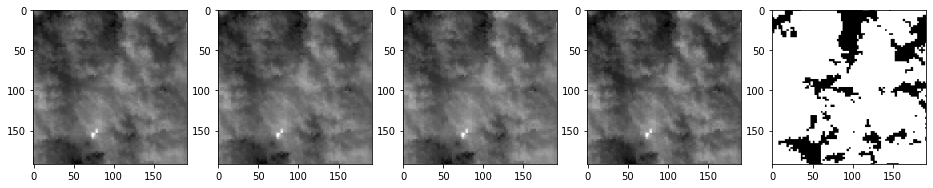

In [6]:
# Visualize random datapoint
idx_viz = np.random.randint(len(ds_train), dtype=int)
data_viz = ds_train[idx_viz]
img_viz = data_viz[0]
msk_viz = data_viz[1]

fig = plt.figure(figsize=(16,9))
plt.subplot(1, 5, 1)
plt.imshow(img_viz[0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(img_viz[1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(img_viz[2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(img_viz[3], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(msk_viz[0], cmap='gray')
plt.show()

In [7]:
# Get DataLoaders from Datasets
dl_train = DataLoader(ds_train, batch_size=batch_sz, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_sz, shuffle=True)

In [8]:
# Define model, optimizer, and loss
model = CloudNet()
optimizer = optim.Adam(model.parameters(), lr=starting_learning_rate)
criterion = JaccardLoss()
# Define training args
args_dict = {
    'batch_size': batch_sz,
    'learning_rate': starting_learning_rate,
    'iterations': 50,
    'gpu_id': 0,
    'device': 'cuda'
}
# Define TB writer
log_dir = "C:/Users/Neil/runs/run1/"
writer = SummaryWriter(log_dir=log_dir)

In [9]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [10]:
train(model=model, criterion=criterion, writer=writer, train_data=dl_train, val_data=dl_val, args=args_dict)

  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 345 is {'jaccard': 0.5040166199553845, 'precision': 0.5040166182321876, 'recall': 1.0, 'specificity': 0.046511627906976744, 'accuracy': 0.5040167689874154}


 45%|████████████████████████████████████                                            | 155/344 [01:24<01:40,  1.89it/s]

Saved model after 500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 689 is {'jaccard': 0.5092561381847359, 'precision': 0.5092561627982104, 'recall': 0.9999998837406925, 'specificity': 0.872089892712077, 'accuracy': 0.5188269513241975}


 91%|████████████████████████████████████████████████████████████████████████▌       | 312/344 [02:36<00:17,  1.82it/s]

Saved model after 1000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 1033 is {'jaccard': 0.5761991586796072, 'precision': 0.5915625784756643, 'recall': 0.9585484662400802, 'specificity': 0.8868609560527648, 'accuracy': 0.6518549717132566}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 1377 is {'jaccard': 0.5807944200066633, 'precision': 0.5813927497977502, 'recall': 0.9983434170618585, 'specificity': 0.9932203287391005, 'accuracy': 0.6377816320109712}


 36%|████████████████████████████▊                                                   | 124/344 [00:59<01:56,  1.89it/s]

Saved model after 1500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 1721 is {'jaccard': 0.6137372085521388, 'precision': 0.616286746559251, 'recall': 0.992807460475038, 'specificity': 0.9850809484613364, 'accuracy': 0.6862106102204214}


 81%|█████████████████████████████████████████████████████████████████               | 280/344 [02:12<00:35,  1.82it/s]

Saved model after 2000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 2065 is {'jaccard': 0.6287829803172932, 'precision': 0.6331515768119738, 'recall': 0.9884731302549329, 'specificity': 0.9771807943573947, 'accuracy': 0.711475786013906}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 2409 is {'jaccard': 0.6494503059359484, 'precision': 0.6581446304202054, 'recall': 0.9813478452633405, 'specificity': 0.9551844381739129, 'accuracy': 0.7357973184332427}


 26%|█████████████████████▍                                                           | 91/344 [00:43<01:55,  2.19it/s]

Saved model after 2500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 2753 is {'jaccard': 0.6740989872189456, 'precision': 0.6959335317232428, 'recall': 0.9556870076301444, 'specificity': 0.9281547678679736, 'accuracy': 0.7685058560295602}


 72%|█████████████████████████████████████████████████████████▋                      | 248/344 [01:57<00:52,  1.83it/s]

Saved model after 3000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 3097 is {'jaccard': 0.6692760403073111, 'precision': 0.6870449589061763, 'recall': 0.9643424310653879, 'specificity': 0.9349256496228399, 'accuracy': 0.7650099433156359}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 3441 is {'jaccard': 0.6743946404651154, 'precision': 0.6981051508341166, 'recall': 0.9554457479801114, 'specificity': 0.9277240612531574, 'accuracy': 0.7723891969369692}


 17%|██████████████▏                                                                  | 60/344 [00:28<02:38,  1.79it/s]

Saved model after 3500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 3785 is {'jaccard': 0.6738557323466899, 'precision': 0.6913257172954606, 'recall': 0.9651777958425668, 'specificity': 0.9423951969550702, 'accuracy': 0.7686996597362924}


 63%|██████████████████████████████████████████████████▏                             | 216/344 [01:43<01:07,  1.91it/s]

Saved model after 4000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 4129 is {'jaccard': 0.6796997542991194, 'precision': 0.7100871718118977, 'recall': 0.9424994992937733, 'specificity': 0.9071793403719512, 'accuracy': 0.776625402867397}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 4473 is {'jaccard': 0.6114545644715775, 'precision': 0.613972851722165, 'recall': 0.9929177195214788, 'specificity': 0.9811983284187035, 'accuracy': 0.6873823169926006}


  8%|██████▌                                                                          | 28/344 [00:13<02:49,  1.86it/s]

Saved model after 4500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 4817 is {'jaccard': 0.662392529290776, 'precision': 0.6714144266712777, 'recall': 0.9797893174157116, 'specificity': 0.9614371836472239, 'accuracy': 0.752066521065488}


 53%|██████████████████████████████████████████▊                                     | 184/344 [01:27<01:24,  1.88it/s]

Saved model after 5000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 5161 is {'jaccard': 0.6190889647533727, 'precision': 0.6219695653286649, 'recall': 0.9917242315505389, 'specificity': 0.9827618873747195, 'accuracy': 0.6994134952090245}


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 339/344 [02:40<00:02,  2.07it/s]

Saved model after 5500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 5505 is {'jaccard': 0.6896252018767733, 'precision': 0.7170821142762515, 'recall': 0.9477973622099861, 'specificity': 0.9259188398231902, 'accuracy': 0.7833257042972419}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 5849 is {'jaccard': 0.676087947432385, 'precision': 0.6901547977976045, 'recall': 0.9717541686481772, 'specificity': 0.948698412247085, 'accuracy': 0.7686549646629819}


 44%|███████████████████████████████████▎                                            | 152/344 [01:12<01:44,  1.83it/s]

Saved model after 6000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 6193 is {'jaccard': 0.6831702960785045, 'precision': 0.7032601277572244, 'recall': 0.9616195651080375, 'specificity': 0.9342472833528327, 'accuracy': 0.779289338202458}


 90%|███████████████████████████████████████████████████████████████████████▋        | 308/344 [02:26<00:18,  1.90it/s]

Saved model after 6500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 6537 is {'jaccard': 0.6823906437602154, 'precision': 0.6982143203852449, 'recall': 0.9689815486054147, 'specificity': 0.950402179390587, 'accuracy': 0.7738403673973263}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 6881 is {'jaccard': 0.6705714169629785, 'precision': 0.6813548805794883, 'recall': 0.9760465591464369, 'specificity': 0.9578853368090194, 'accuracy': 0.7600418818453432}


 35%|███████████████████████████▉                                                    | 120/344 [00:57<01:54,  1.95it/s]

Saved model after 7000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 7225 is {'jaccard': 0.692530102161474, 'precision': 0.7184393333791828, 'recall': 0.9512168049762334, 'specificity': 0.9197744817754351, 'accuracy': 0.7873158340268908}


 80%|████████████████████████████████████████████████████████████████▏               | 276/344 [02:10<00:39,  1.74it/s]

Saved model after 7500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 7569 is {'jaccard': 0.6390282270866771, 'precision': 0.643184742458224, 'recall': 0.9893761862397119, 'specificity': 0.976696037450425, 'accuracy': 0.7183621273409666}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 7913 is {'jaccard': 0.6899519022120986, 'precision': 0.7159725989725715, 'recall': 0.9460798895541427, 'specificity': 0.9226822940457258, 'accuracy': 0.7878870176602508}


 26%|████████████████████▋                                                            | 88/344 [00:41<02:17,  1.87it/s]

Saved model after 8000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 8257 is {'jaccard': 0.693804071393124, 'precision': 0.7128021361686432, 'recall': 0.9624771513249392, 'specificity': 0.9391747561064868, 'accuracy': 0.7879329601046193}


 71%|████████████████████████████████████████████████████████▋                       | 244/344 [01:56<00:54,  1.84it/s]

Saved model after 8500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 8601 is {'jaccard': 0.7277356601038645, 'precision': 0.7632462448882595, 'recall': 0.9386277284447887, 'specificity': 0.9214768787380001, 'accuracy': 0.827892339012093}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 8945 is {'jaccard': 0.7593409919808077, 'precision': 0.7989919416504685, 'recall': 0.9357251031440549, 'specificity': 0.9221230483590749, 'accuracy': 0.8573145031154265}


 16%|████████████▉                                                                    | 55/344 [00:26<02:21,  2.05it/s]

Saved model after 9000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 9289 is {'jaccard': 0.6903236158365427, 'precision': 0.7108169902982897, 'recall': 0.9607048014125245, 'specificity': 0.9359783778355789, 'accuracy': 0.7863215168009126}


 62%|█████████████████████████████████████████████████▎                              | 212/344 [01:41<01:11,  1.85it/s]

Saved model after 9500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 9633 is {'jaccard': 0.752352902362513, 'precision': 0.8148374428325752, 'recall': 0.9057847609022782, 'specificity': 0.8917323576668252, 'accuracy': 0.8556036261774416}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 9977 is {'jaccard': 0.6929869260205779, 'precision': 0.7274421277413377, 'recall': 0.9380542385365256, 'specificity': 0.9110072404322677, 'accuracy': 0.7933418716599131}


  7%|█████▋                                                                           | 24/344 [00:11<02:47,  1.92it/s]

Saved model after 10000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 10321 is {'jaccard': 0.6564006049965703, 'precision': 0.6712488699524412, 'recall': 0.9662120803221661, 'specificity': 0.9409746456825601, 'accuracy': 0.755210639297071}


 52%|█████████████████████████████████████████▊                                      | 180/344 [01:25<01:28,  1.85it/s]

Saved model after 10500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 10665 is {'jaccard': 0.7169960373362829, 'precision': 0.7381249763001874, 'recall': 0.9623823294945436, 'specificity': 0.942392364475966, 'accuracy': 0.8116519669005641}


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 336/344 [02:40<00:04,  1.79it/s]

Saved model after 11000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 11009 is {'jaccard': 0.6886997278346572, 'precision': 0.735111718139998, 'recall': 0.9187847660062609, 'specificity': 0.891537809168583, 'accuracy': 0.7921775344132947}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 11353 is {'jaccard': 0.7724411224209985, 'precision': 0.8397930266150077, 'recall': 0.9075879061957348, 'specificity': 0.8935368223180057, 'accuracy': 0.8688048957966289}


 43%|██████████████████████████████████▍                                             | 148/344 [01:10<01:44,  1.87it/s]

Saved model after 11500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 11697 is {'jaccard': 0.7578318462122319, 'precision': 0.7962129568302161, 'recall': 0.9394920438370934, 'specificity': 0.9260553147382097, 'accuracy': 0.8552183486237128}


 88%|██████████████████████████████████████████████████████████████████████▋         | 304/344 [02:24<00:21,  1.90it/s]

Saved model after 12000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 12041 is {'jaccard': 0.6834764839258305, 'precision': 0.7075909581474421, 'recall': 0.9519243886373354, 'specificity': 0.9262830245009828, 'accuracy': 0.7787817752722537}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 12385 is {'jaccard': 0.6898571193911308, 'precision': 0.7093972812486405, 'recall': 0.9611842481846898, 'specificity': 0.9435955051904906, 'accuracy': 0.7884807949590381}


 34%|██████████████████████████▉                                                     | 116/344 [00:55<02:00,  1.90it/s]

Saved model after 12500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 12729 is {'jaccard': 0.7274743121030719, 'precision': 0.765112059891675, 'recall': 0.9362682904733646, 'specificity': 0.9207774809789618, 'accuracy': 0.8273343220732332}


 79%|███████████████████████████████████████████████████████████████                 | 271/344 [02:07<00:34,  2.15it/s]

Saved model after 13000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 13073 is {'jaccard': 0.698787089523881, 'precision': 0.7202032799323563, 'recall': 0.9610729678914375, 'specificity': 0.9416921253218102, 'accuracy': 0.7936569284360381}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 13417 is {'jaccard': 0.7289353867256364, 'precision': 0.7929556756840834, 'recall': 0.8991376120138889, 'specificity': 0.8901240278623708, 'accuracy': 0.842054318526685}


 24%|███████████████████▊                                                             | 84/344 [00:40<02:18,  1.87it/s]

Saved model after 13500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 13761 is {'jaccard': 0.7961739433366198, 'precision': 0.8351996411079003, 'recall': 0.9439601897424844, 'specificity': 0.9369305999355095, 'accuracy': 0.8827818868378857}


 70%|███████████████████████████████████████████████████████▊                        | 240/344 [01:54<00:55,  1.89it/s]

Saved model after 14000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 14105 is {'jaccard': 0.7522026248449503, 'precision': 0.8010305080017868, 'recall': 0.924224512021403, 'specificity': 0.9066608559316496, 'accuracy': 0.8479568831521673}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 14449 is {'jaccard': 0.7723191314658453, 'precision': 0.7963888302365748, 'recall': 0.9612916726271049, 'specificity': 0.9557343397217898, 'accuracy': 0.8638823657595514}


 15%|████████████                                                                     | 51/344 [00:24<02:16,  2.15it/s]

Saved model after 14500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 14793 is {'jaccard': 0.7892755540304406, 'precision': 0.816326808733685, 'recall': 0.9599505501217759, 'specificity': 0.9530976541054055, 'accuracy': 0.8788593087029454}


 60%|████████████████████████████████████████████████▎                               | 208/344 [01:38<01:12,  1.88it/s]

Saved model after 15000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 15137 is {'jaccard': 0.8242604288943979, 'precision': 0.8658707993387266, 'recall': 0.9448897850035705, 'specificity': 0.9364738530309139, 'accuracy': 0.9020736869971514}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 15481 is {'jaccard': 0.7660935441421908, 'precision': 0.7823631710112297, 'recall': 0.9733781905955895, 'specificity': 0.967566488297065, 'accuracy': 0.8568862916233864}


  6%|████▋                                                                            | 20/344 [00:10<03:00,  1.80it/s]

Saved model after 15500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 15825 is {'jaccard': 0.774383139471675, 'precision': 0.7919741768236719, 'recall': 0.9705885173742553, 'specificity': 0.9653960126207832, 'accuracy': 0.8658886736910957}


 51%|████████████████████████████████████████▉                                       | 176/344 [01:23<01:32,  1.82it/s]

Saved model after 16000 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 16169 is {'jaccard': 0.8226545508517775, 'precision': 0.891548953589593, 'recall': 0.9155202841585527, 'specificity': 0.9125081418738696, 'accuracy': 0.9068042796048847}


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 332/344 [02:37<00:06,  1.87it/s]

Saved model after 16500 batches.


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 16513 is {'jaccard': 0.7593182335759319, 'precision': 0.7937250611228565, 'recall': 0.9472158217931412, 'specificity': 0.9362254538871632, 'accuracy': 0.8495006577707795}


  0%|                                                                                          | 0/344 [00:00<?, ?it/s]

average similarity for iteration 16857 is {'jaccard': 0.8371690400811129, 'precision': 0.8837244428194553, 'recall': 0.9405920409052513, 'specificity': 0.9354759013673489, 'accuracy': 0.9125873785815702}


 42%|█████████████████████████████████▍                                              | 144/344 [01:09<01:52,  1.78it/s]

Saved model after 17000 batches.


100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [03:01<00:00,  2.11s/it]

average similarity for iteration 17201 is {'jaccard': 0.8225460932698361, 'precision': 0.9129840848491618, 'recall': 0.8907525689695427, 'specificity': 0.8948034428937202, 'accuracy': 0.9079339509282507}
